Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

Load the dataset from the Google Drive

In [2]:
df = pd.read_csv('C:/Users/OJO ABAYOMI MOSES/Documents/ECG-detection-main/mitbih_train.csv', header=None)
df2 = pd.read_csv('C:/Users/OJO ABAYOMI MOSES/Documents/ECG-detection-main/mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Dataset Info : **

Arrhythmia Dataset

Number of Samples: 109446

Number of Categories: 5

Sampling Frequency: 125Hz

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

-N : Non-ecotic beats (normal beat)

-S : Supraventricular ectopic beats

-V : Ventricular ectopic beats

-F : Fusion Beats

-Q : Unknown Beats

Samples on each classes

In [4]:
df[187]=df[187].astype(int)
df[187].value_counts()

187
0    90589
4     8039
2     7236
1     2779
3      803
Name: count, dtype: int64

In [5]:
X=df.iloc[:,:-1]
y=df.iloc[:, -1].astype(int)

Splitting the Dataset into train and test values

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True, stratify=y)

In [7]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (76612, 187)
y_train (76612,)
X_test (32834, 187)
y_test (32834,)


Applying the ADASYN Algorithm to handle imbalanced dataset

In [8]:
asy = ADASYN(random_state=42)
X_res, y_res = asy.fit_resample(X_train, y_train)

Shape of Train and Test values

In [9]:

X_train=np.array(X_res)
X_test=np.array(X_test)
y_train=np.array(y_res)
y_test=np.array(y_test)

In [10]:

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (317133, 187)
y_train (317133,)
X_test (32834, 187)
y_test (32834,)


Expanding the X_train and X_test Dimensions for model architecture to match

In [11]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

Converting the Targets into categorical form

In [12]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

After expanding the dimension of train and test values

In [13]:

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (317133, 187, 1)
y_train (317133, 5)
X_test (32834, 187, 1)
y_test (32834, 5)


Importing the Libraries for Neural Network

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model,model_from_json
from tensorflow.keras.layers import Input, Dense, Convolution1D, MaxPool1D,Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping

Neural Network 1

In [15]:
n_obs, feature, depth = X_train.shape
batch_size = 500
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 183, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 183, 32)   │      5,152 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 183, 32)   │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 183, 32)   │      5,152 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 183, 32)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 183, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 90, 32)    │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 90, 32)    │      5,152 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 90, 32)    │          0 │ conv1d_5[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 90, 32)    │      5,152 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 90, 32)    │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 90, 32)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 43, 32)    │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 43, 32)    │      5,152 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 43, 32)    │          0 │ conv1d_7[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 43, 32)    │      5,152 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 43, 32)    │          0 │ conv1d_8[0][0],   │
│                     │                   │            │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 43, 32)    │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 50,853 (198.64 KB)

 Trainable params: 50,853 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Training Phase

In [16]:
import math
batch_size = 512
def exp_decay(epoch):
    initial_lrate = 3e-5
    k = 0.75
    t = n_obs // (10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k * t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

adam = Adam(learning_rate=3e-5, beta_1=0.9, beta_2=0.999)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[lrate])



Epoch 1/100
620/620 - 95s - 154ms/step - accuracy: 0.4703 - loss: 1.2829 - val_accuracy: 0.5062 - val_loss: 1.1535 - learning_rate: 3.0000e-05
Epoch 2/100
620/620 - 98s - 159ms/step - accuracy: 0.6427 - loss: 0.9226 - val_accuracy: 0.6935 - val_loss: 0.7945 - learning_rate: 3.0000e-05
Epoch 3/100
620/620 - 84s - 135ms/step - accuracy: 0.7444 - loss: 0.6969 - val_accuracy: 0.7473 - val_loss: 0.6833 - learning_rate: 3.0000e-05
Epoch 4/100
620/620 - 79s - 127ms/step - accuracy: 0.7952 - loss: 0.5744 - val_accuracy: 0.7360 - val_loss: 0.6991 - learning_rate: 3.0000e-05
Epoch 5/100
620/620 - 79s - 128ms/step - accuracy: 0.8223 - loss: 0.5029 - val_accuracy: 0.7915 - val_loss: 0.5549 - learning_rate: 3.0000e-05
Epoch 6/100
620/620 - 85s - 137ms/step - accuracy: 0.8417 - loss: 0.4494 - val_accuracy: 0.7924 - val_loss: 0.5465 - learning_rate: 3.0000e-05
Epoch 7/100
620/620 - 95s - 153ms/step - accuracy: 0.8565 - loss: 0.4096 - val_accuracy: 0.8299 - val_loss: 0.4659 - learning_rate: 3.0000e-05

Calculating the metrics values towards test data


In [17]:
y_pred = model.predict(X_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('Accuracy', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
#print('ROC AUC score:', roc_auc_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('confusion matrix:')
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     27177
           1       0.54      0.87      0.66       833
           2       0.89      0.93      0.91      2171
           3       0.47      0.87      0.61       241
           4       0.95      0.99      0.97      2412

    accuracy                           0.96     32834
   macro avg       0.77      0.92      0.83     32834
weighted avg       0.97      0.96      0.96     32834

Accuracy 0.9563562161174393
confusion matrix:
[[26062   583   225   200   107]
 [   95   724     8     3     3]
 [   75    41  2012    35     8]
 [   12     1    18   210     0]
 [   13     1     5     0  2393]]


<Axes: >

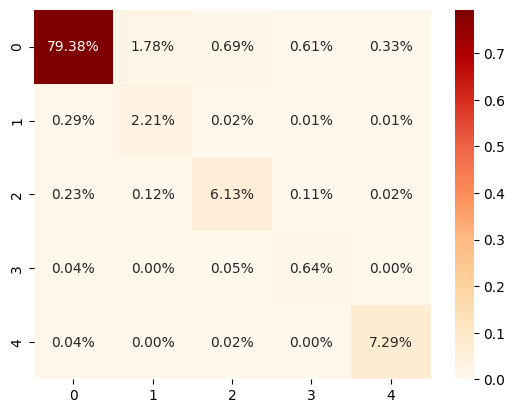

In [18]:
import seaborn as sns
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='OrRd')

 Visualisation

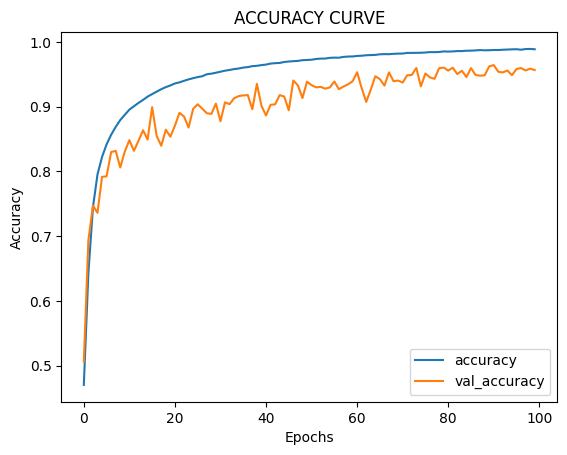

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ACCURACY CURVE')
plt.legend(['accuracy','val_accuracy'], loc='best')
plt.show()

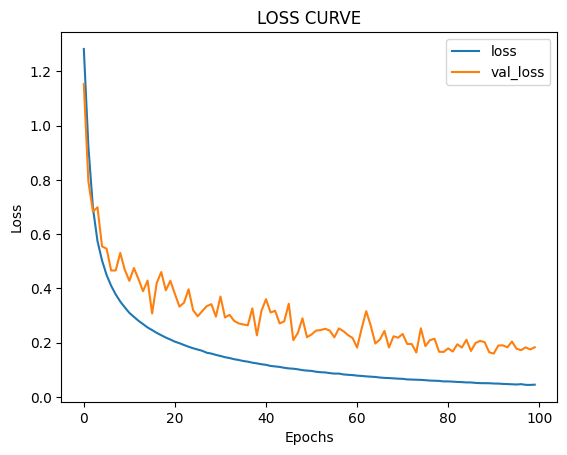

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LOSS CURVE')
plt.legend(['loss','val_loss'], loc='best')
plt.show()

Saving the trained model

In [21]:
model.save(r'C:\Users\OJO ABAYOMI MOSES\3D Objects\model.h5')
print('saved the model to disk')

saved the model to disk


In [22]:
test

NameError: name 'test' is not defined

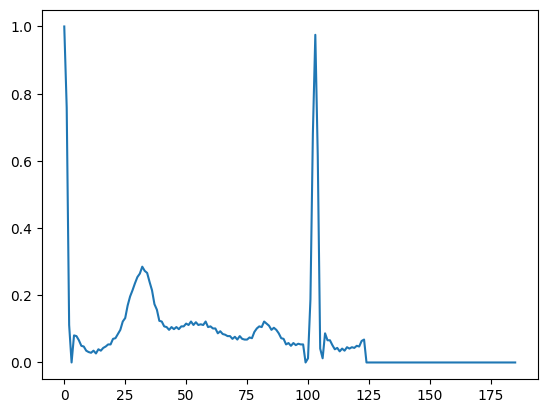

In [ ]:
plt.plot(test.iloc[0,:186])

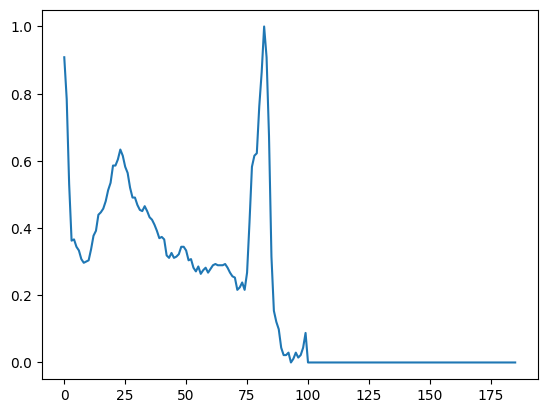

In [ ]:
plt.plot(test.iloc[1,:186])